In [1]:
import os
import sys
import pickle
import torch
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW


import warnings
warnings.filterwarnings('ignore')

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Config():
    use_gpu = True
    gpu_id = 0
    preprocess = True
    bert_path = '/root/pretrained/bert-base-chinese'
    data_path = '/root/data/public/ChnSentiCorp'

    # 预处理后存放文件位置
    out_path = 'data/out'
    max_len = 256
    batch_size = 8
    dropout = 0.3
    num_hidden = 768
    num_classes = 119
    train_batch_size = 2
    epoch = 1
    seed = 1234
    early_stopping_patience = 6
    model_name = 'bert'
    train_log = 10
    log_interval = 10
cfg = Config()
cfg.cwd = os.getcwd()

In [3]:
# use GPU
if cfg.use_gpu and torch.cuda.is_available():
    device = torch.device('cuda', cfg.gpu_id)
else:
    device = torch.device('cpu')

In [4]:
# 设置随机种子
def manual_seed(seed: int = 1) -> None:
    """
        设置seed。
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #if torch.cuda.CUDA_ENABLED and use_deterministic_cudnn:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
manual_seed(1234)

In [5]:
# dataload 加载数据集
sys.path.append('/root/projects/nlp-code-examples')
from src.easy_bert.TextClassifiy import tools

train_data_path = os.path.join('/root/projects/nlp-code-examples/example/TextClassifiy/data/', 'train.pkl')
valid_data_path = os.path.join('/root/projects/nlp-code-examples/example/TextClassifiy/data/', 'dev.pkl')
test_data_path = os.path.join('/root/projects/nlp-code-examples/example/TextClassifiy/data/', 'dev.pkl')

train_dataset = tools.CustomDataset(train_data_path)
valid_dataset = tools.CustomDataset(valid_data_path)
test_dataset = tools.CustomDataset(test_data_path)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=tools.collate_fn(cfg))
valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=tools.collate_fn(cfg))
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=True, collate_fn=tools.collate_fn(cfg))

In [7]:
# 构建模型
import torch.nn as nn

from transformers import BertModel

class BasicBert(nn.Module):
    def __init__(self, cfg):
        super(BasicBert, self).__init__()
        self.bert = BertModel.from_pretrained(cfg.bert_path)
        self.bert_drop = nn.Dropout(cfg.dropout)
        self.out = nn.Linear(cfg.num_hidden, cfg.num_classes)

    def forward(self, x):
        _, o2 = self.bert(**x, return_dict=False)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        
        return output

In [8]:
model = BasicBert(cfg)
model.to(device)
pass

Some weights of the model checkpoint at /root/pretrained/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"] # 官方默认
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [10]:
from transformers import get_linear_schedule_with_warmup
num_train_steps = int(len(train_dataset) / cfg.train_batch_size * cfg.epoch)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

criterion = nn.CrossEntropyLoss()

In [11]:
best_f1, best_epoch = -1, 0
es_loss, es_f1, es_epoch, es_patience, best_es_epoch, best_es_f1, es_path, best_es_path = 1e8, -1, 0, 0, 0, -1, '', ''
train_losses, valid_losses = [], []

In [12]:
losses = []
from sklearn.metrics import precision_recall_fscore_support
import torch.nn.functional as F

def trainer(dataloader, model, criterion, optimizer):
    for batch_idx, (x, y) in enumerate(dataloader, 1):
        for key, value in x.items():
            x[key] = value.to(device)
        y = y.to(device)
        optimizer.zero_grad() # 梯度清0
        y_pred = model(x)
        # loss = F.cross_entropy(y_pred, y.long())
        loss = criterion(y_pred, y.long())
        loss.backward() # 反向传播
        optimizer.step() # 提督更新
        losses.append(loss.item())
        if batch_idx % 10 == 0:
            # print('loss:', loss.item())
            y_pred = torch.max(y_pred, 1)[1].cpu().numpy()
            y_true = y.cpu().detach().numpy()
            print(y_pred)
            print(y_true)
            p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', warn_for=tuple())
            # print(f"""p:{p}, r:{r}, f1:{f1}""")
    plt.plot(losses)
    plt.title(f'epoch {1} train loss')
    plt.show()

[70 70  1 70 17  1 70 70]
[ 70.  70. 118.  62.  49.  70.  10.  53.]
[70 70 70 70 70 70 70 70]
[107.  96.  18.  78.  94. 103.  29.  28.]
[70 70 70 70 70 70 70 70]
[ 19.   9.  28.  71.  16. 112. 111.  83.]
[70 70 70 70 70 70 70 70]
[70. 72. 17. 17. 38. 70. 26. 47.]
[17 70 70 70 17 17 17 70]
[17. 95. 95. 70. 17. 36. 18. 17.]
[70 70 17 70 70 70 17 70]
[ 95.   9.  20. 111. 106.  94.  24.  70.]
[70 70 70 70 70 17 17 17]
[ 70. 118.  33.  28.  99.  18.  18.  17.]
[70 17 17 17 17 70 70 70]
[34. 36. 18. 17. 71. 53. 70. 70.]
[17 70 70 70 17 70 95 17]
[18. 91. 77. 56. 71.  8. 95. 18.]
[ 25 106  18  71  18  18  17  17]
[25. 46. 13. 75. 15. 16. 28. 17.]
[17 70 17 70 70 70 70 71]
[13.  1. 14. 70. 17. 71. 64. 55.]
[95 17 18 70 70 70 25 95]
[ 54.  17.  16. 113.  36. 103.  25. 110.]
[70 70 18 18 17 70 18 18]
[75. 70. 20. 20. 22. 59. 13. 20.]
[70 17 18 18 53 70 18 70]
[28. 25. 19. 22. 28. 70. 17. 70.]
[71 70 70 17 34 17  8 70]
[ 71.  96.  70.  19.  97.  21. 116.  48.]
[17 70 70 71 70 71 18 95]
[ 18.  70.

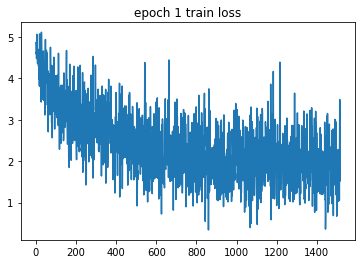

In [13]:
trainer(train_dataloader, model, criterion, optimizer)

In [60]:
y_true = y.cpu().detach().numpy()

In [69]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [61]:
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', warn_for=tuple())

In [67]:
_, _, acc, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', warn_for=tuple())

In [68]:
acc

0.46875

In [71]:
acc = accuracy_score(y_true, y_pred)

In [72]:
acc

0.46875

In [79]:
loss

tensor(0.7974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)